# 6 Functions and Parameter Estimation
## 6.1 Fitting Functions to Pseudo Data
In the example below, a pseudo-data set is produced and a model fitted to it.

ROOT offers various minimisation algorithms to minimise a \\\(\\chi\^\{2\}\\\) or a negative log-likelihood function. The default minimiser is MINUIT, a package originally implemented in the FORTRAN programming language. A C++ version is also available, MINUIT2, as well as Fumili (Silin 1983) an algorithm optimised for fitting. The minimisation algorithms can be selected using the static functions of the [```ROOT::Math::MinimizerOptions```](https://root.cern.ch/doc/v606/classROOT_1_1Math_1_1MinimizerOptions.html) class. Steering options for the minimiser, such as the convergence tolerance or the maximum number of function calls, can also be set using the methods of this class. All currently implemented minimisers are documented in the reference documentation of ROOT: have a look for example to the [```ROOT::Math::Minimizer```](https://root.cern.ch/doc/v606/classROOT_1_1Math_1_1Minimizer.html) class documentation. The complication level of the code below is intentionally a little higher than in the previous examples. 

Let’s go through the code, step by step to understand what is going on:

* First we create a simple function to ease the make-up of lines. Remember that the class TF1 inherits from [TAttLine](https://root.cern.ch/doc/master/classTAttLine.html).

In [1]:
%jsroot on

In [2]:
%%cpp -d
void format_line(TAttLine* line,int col,int sty){
line->SetLineWidth(5); line->SetLineColor(col);
line->SetLineStyle(sty);}

* Here we create a definition of a customised function, namely a Gaussian (the “signal”) plus a parabolic function, the “background”.

In [3]:
%%cpp -d
double the_gausppar(double* vars, double* pars){
return pars[0]*TMath::Gaus(vars[0],pars[1],pars[2])+pars[3]+pars[4]*vars[0]+pars[5]*vars[0]*vars[0];}

* Some make-up for the Canvas. In particular we want that the parameters of the fit appear very clearly and nicely on the plot. 

In [4]:
auto canvas_6_1=new TCanvas("canvas_6_1","canvas_6_1");
gStyle->SetOptTitle(0); gStyle->SetOptStat(0);
gStyle->SetOptFit(1111); gStyle->SetStatBorderSize(0);
gStyle->SetStatX(.89); gStyle->SetStatY(.89);

TF1 parabola("parabola","[0]+[1]*x+[2]*x**2",0,20);
format_line(&parabola,kBlue,2);

TF1 gaussian("gaussian","[0]*TMath::Gaus(x,[1],[2])",0,20);
format_line(&gaussian,kRed,2);

* Next we define and initialize an instance of TF1.

In [5]:
TF1 gausppar("gausppar",the_gausppar,-0,20,6);
double a=15; double b=-1.2; double c=.03;
double normal=4; double mean=7; double sigma=1;
gausppar.SetParameters(normal,mean,sigma,a,b,c);
gausppar.SetParNames("Normal","Mean","Sigma","a","b","c");
format_line(&gausppar,kBlue,1);

* Followed by the definition and the filling of a histogram.

In [6]:
TH1F histo("histo","Signal plus background;X vals;Y Vals",50,0,20);
histo.SetMarkerStyle(8);

// Fake the data
for (int i=1;i<=5000;++i) histo.Fill(gausppar.GetRandom());

* For convenience, the same function as for the generation of the pseudo-data is used in the fit; hence, we need to reset the function parameters. This part of the code is very important for each fit procedure, as it sets the initial values of the fit.

In [7]:
// Reset the parameters before the fit and set
// by eye a peak at 6 with an area of more or less 50
gausppar.SetParameter(0,50);
gausppar.SetParameter(1,6);
int npar=gausppar.GetNpar();
for (int ipar=2;ipar<npar;++ipar) gausppar.SetParameter(ipar,1);

* Next a very simple command, well known by now: fit the function to the histogram.

In [8]:
// perform fit ...
auto fitResPtr = histo.Fit(&gausppar, "S");

 FCN=42.0305 FROM MIGRAD    STATUS=CONVERGED    1207 CALLS        1208 TOTAL
                     EDM=5.17306e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Normal       5.78269e+01   7.94068e+00   5.77561e-02   4.28977e-05
   2  Mean         7.01009e+00   1.35383e-01  -3.22514e-04   7.29243e-05
   3  Sigma        9.23834e-01   1.57793e-01  -2.59746e-04   2.77085e-03
   4  a            2.00626e+02   5.50591e+00   2.33533e-03  -2.57315e-04
   5  b           -1.67332e+01   1.03021e+00  -1.03565e-04   1.76478e-04
   6  c            4.43814e-01   4.63690e-02  -4.30880e-05   2.61849e-02


* We then retrieve the output from the fit. Here, we simply print the fit result and access and print the covariance matrix of the parameters.

In [9]:
// ... and retrieve fit results
fitResPtr->Print(); // print fit results
// get covariance Matrix an print it
TMatrixDSym covMatrix (fitResPtr->GetCovarianceMatrix());
covMatrix.Print();

// Set the values of the gaussian and parabola
for (int ipar=0;ipar<3;ipar++){
    gaussian.SetParameter(ipar,gausppar.GetParameter(ipar));
    parabola.SetParameter(ipar,gausppar.GetParameter(ipar+3));
}


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      42.0305
NDf                       =           44
Edm                       =  5.17306e-07
NCalls                    =         1208
Normal                    =      57.8269   +/-   7.94068     
Mean                      =      7.01009   +/-   0.135383    
Sigma                     =     0.923834   +/-   0.157793    
a                         =      200.626   +/-   5.50591     
b                         =     -16.7332   +/-   1.03021     
c                         =     0.443814   +/-   0.046369    

6x6 matrix is as follows

     |      0    |      1    |      2    |      3    |      4    |
----------------------------------------------------------------------
   0 |      63.05     0.08809     -0.5976      -2.663     -0.3044 
   1 |    0.08809     0.01833   -0.005144      0.1111    -0.01496 
   2 |    -0.5976   -0.005144      0.0249     -0.1629   -0.009859 
   3 |     -2.663      0.11

* Finally we plot the pseudo-data, the fitted function and the signal and background components at the best-fit values.

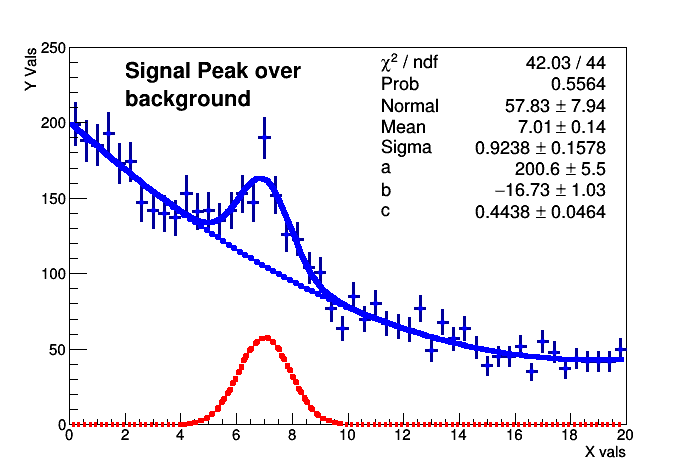

In [10]:
histo.GetYaxis()->SetRangeUser(0,250);
histo.DrawClone("PE");
parabola.DrawClone("Same"); gaussian.DrawClone("Same");
TLatex latex(2,220,"#splitline{Signal Peak over}{background}");
latex.DrawClone("Same");
canvas_6_1->Draw();
// return 0;

Fit of pseudo data: a signal shape over a background trend. This plot is another example of how making a plot “self-explanatory” can help you better displaying your results.

## 6.2 Toy Monte Carlo Experiments
Let us look at a simple example of a toy experiment comparing two methods to fit a function to a histogram, the \\\(\\chi\^\{2\}\\\) method and a method called “binned log-likelihood fit”, both available in ROOT.

As a very simple yet powerful quantity to check the quality of the fit results, we construct for each pseudo-data set the so-called “pull”, the difference of the estimated and the true value of a parameter, normalized to the estimated error on the parameter, \\\(\\frac\{\(p\_\{estim\} \- p\_\{true\}\)\}\{\\sigma\_\{p\}\}\\\). If everything is OK, the distribution of the pull values is a standard normal distribution, i.e. a Gaussian distribution centred around zero with a standard deviation of one.

The macro performs a rather big number of toy experiments, where a histogram is repeatedly filled with Gaussian distributed numbers, representing the pseudo-data in this example. Each time, a fit is performed according to the selected method, and the pull is calculated and filled into a histogram. Here is the code:

In [11]:
%%cpp -d
// Toy Monte Carlo example.
// Check pull distribution to compare chi2 and binned
// log-likelihood methods.

void pull( int n_toys = 10000,
    int n_tot_entries = 100,
    int nbins = 40,
    bool do_chi2=true ){

    TString method_prefix("LogLikelihood");
    if (do_chi2)
        method_prefix="chi2";

    // Create histo
    TH1F h4(method_prefix+"h4",
            method_prefix+" Random Gauss",
            nbins,-4,4);
    h4.SetMarkerStyle(21);
    h4.SetMarkerSize(0.8);
    h4.SetMarkerColor(kRed);

    // Histogram for sigma and pull
    TH1F sigma(method_prefix+" sigma",
               method_prefix+" sigma from gaus fit",
               50,0.5,1.5);
    TH1F pull(method_prefix+" pull",
              method_prefix+" pull from gaus fit",
              50,-4.,4.);
    // Make a nice devided canvas
    auto *canvas_6_2 = new TCanvas(method_prefix+"canvas_6_2",method_prefix+"canvas_6_2",800,400);
    canvas_6_2->Divide(2,1);
    canvas_6_2->cd(1);canvas_6_2->SetGrid();
    
    
    float sig, mean;
    for (int i=0; i<n_toys; i++){
        // Reset histo contents
        h4.Reset();
        // Fill histo
        for ( int j = 0; j<n_tot_entries; j++ )
        h4.Fill(gRandom->Gaus());
        // perform fit
        if (do_chi2) h4.Fit("gaus","q"); // Chi2 fit
        else h4.Fit("gaus","lq"); // Likelihood fit
        // some control output on the way
        if (!(i%100)){
            h4.DrawClone("ep");
            canvas_6_2->Update();
        }

        // Get sigma from fit
        TF1 *fit = h4.GetFunction("gaus");
        sig = fit->GetParameter(2);
        mean= fit->GetParameter(1);
        sigma.Fill(sig);
        pull.Fill(mean/sig * sqrt(n_tot_entries));
       } 
       // end of toy MC loop 
       h4.DrawClone("ep");
        canvas_6_2->Draw();
        canvas_6_2->cd(2);
        // print result
        pull.DrawClone();
        canvas_6_2->Draw();
    
}

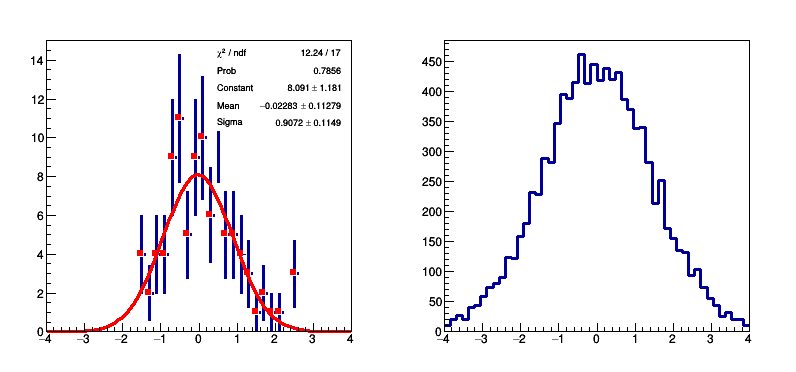

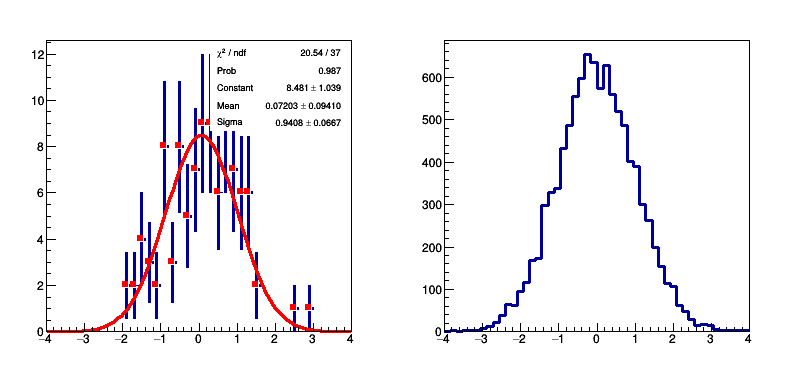

In [12]:
int n_toys=10000;
int n_tot_entries=100;
int n_bins=40;
pull(n_toys,n_tot_entries,n_bins,true);
pull(n_toys,n_tot_entries,n_bins,false);

Your present knowledge of ROOT should be enough to understand all the technicalities behind the macro. Note that the variable pull in line 61 is different from the definition above: instead of the parameter error on mean, the fitted standard deviation of the distribution divided by the square root of the number of entries, ```sig/sqrt(n_tot_entries)```, is used.

* What method exhibits the better performance with the default parameters?

* What happens if you increase the number of entries per histogram by a factor of ten? Why?

The answers to these questions are well beyond the scope of this guide. Basically all books about statistical methods provide a complete treatment of the aforementioned topics.

### ROOT-Primer Navigator

<p id="nav-felt" style="possition:relative; width:50%; float:left;"><a href="5-Histograms.ipynb">&lt;&lt; Previous Chapter 5 Histograms</a></p>
<p id="nav-right" style="possition:relative; width:45%; float:left; text-align:right;"><a href="7-File-IO-and-Parallel-Analysis.ipynb">Next Chapter  7-File IO and Parallel Analysis &gt;&gt;</a></p>